## Import the requirements

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import derl
from derl import EvalRunner, ActorCriticPolicy
from models import ContinuousActorCriticModel
from utils import make_mlp_class, parse_arg_archive
from visualization import state_action_obs_plot, plot_ltc_cell

/Users/renard/miniconda3/envs/nodeRL/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/renard/miniconda3/envs/nodeRL/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/renard/miniconda3/envs/nodeRL/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/renard/miniconda3/envs/nodeRL/lib

## Instanciate the environment

In [2]:
tf.enable_eager_execution()

logdir = 'trained_weights/InvertedPendulumLQReward'
eval_steps = 1024
render = True



run_args = parse_arg_archive(logdir + '/args.txt')

env = derl.env.make(run_args.env_id)
if hasattr(run_args, 'seed'):
    env.seed(run_args.seed)
policy = make_mlp_class(run_args.policy_net, run_args.recurrent_policy, run_args)(env.action_space.shape[0])
value = make_mlp_class(run_args.value_net, run_args.recurrent_value, run_args)(1)
model = ContinuousActorCriticModel(env.observation_space.shape,
                                    env.action_space.shape[0],
                                    policy, value)
model.load_weights(logdir+'/model') # load the weights from the logged policy
policy_object = ActorCriticPolicy(model)
runner = EvalRunner(env, policy_object, eval_steps, render)

/Users/renard/Documents/etudes/EPFLMA4/LTC/CTNN_Policies_DERL/derl/derl/env/summarize.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.had_ended_episodes = np.zeros(nenvs, dtype=np.bool)
2022-05-28 15:07:19.816373: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA


## Run the experiment

In [3]:
trajectory = runner.get_next()

Creating window glfw
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


## Plots

## Hidden state v.s env state

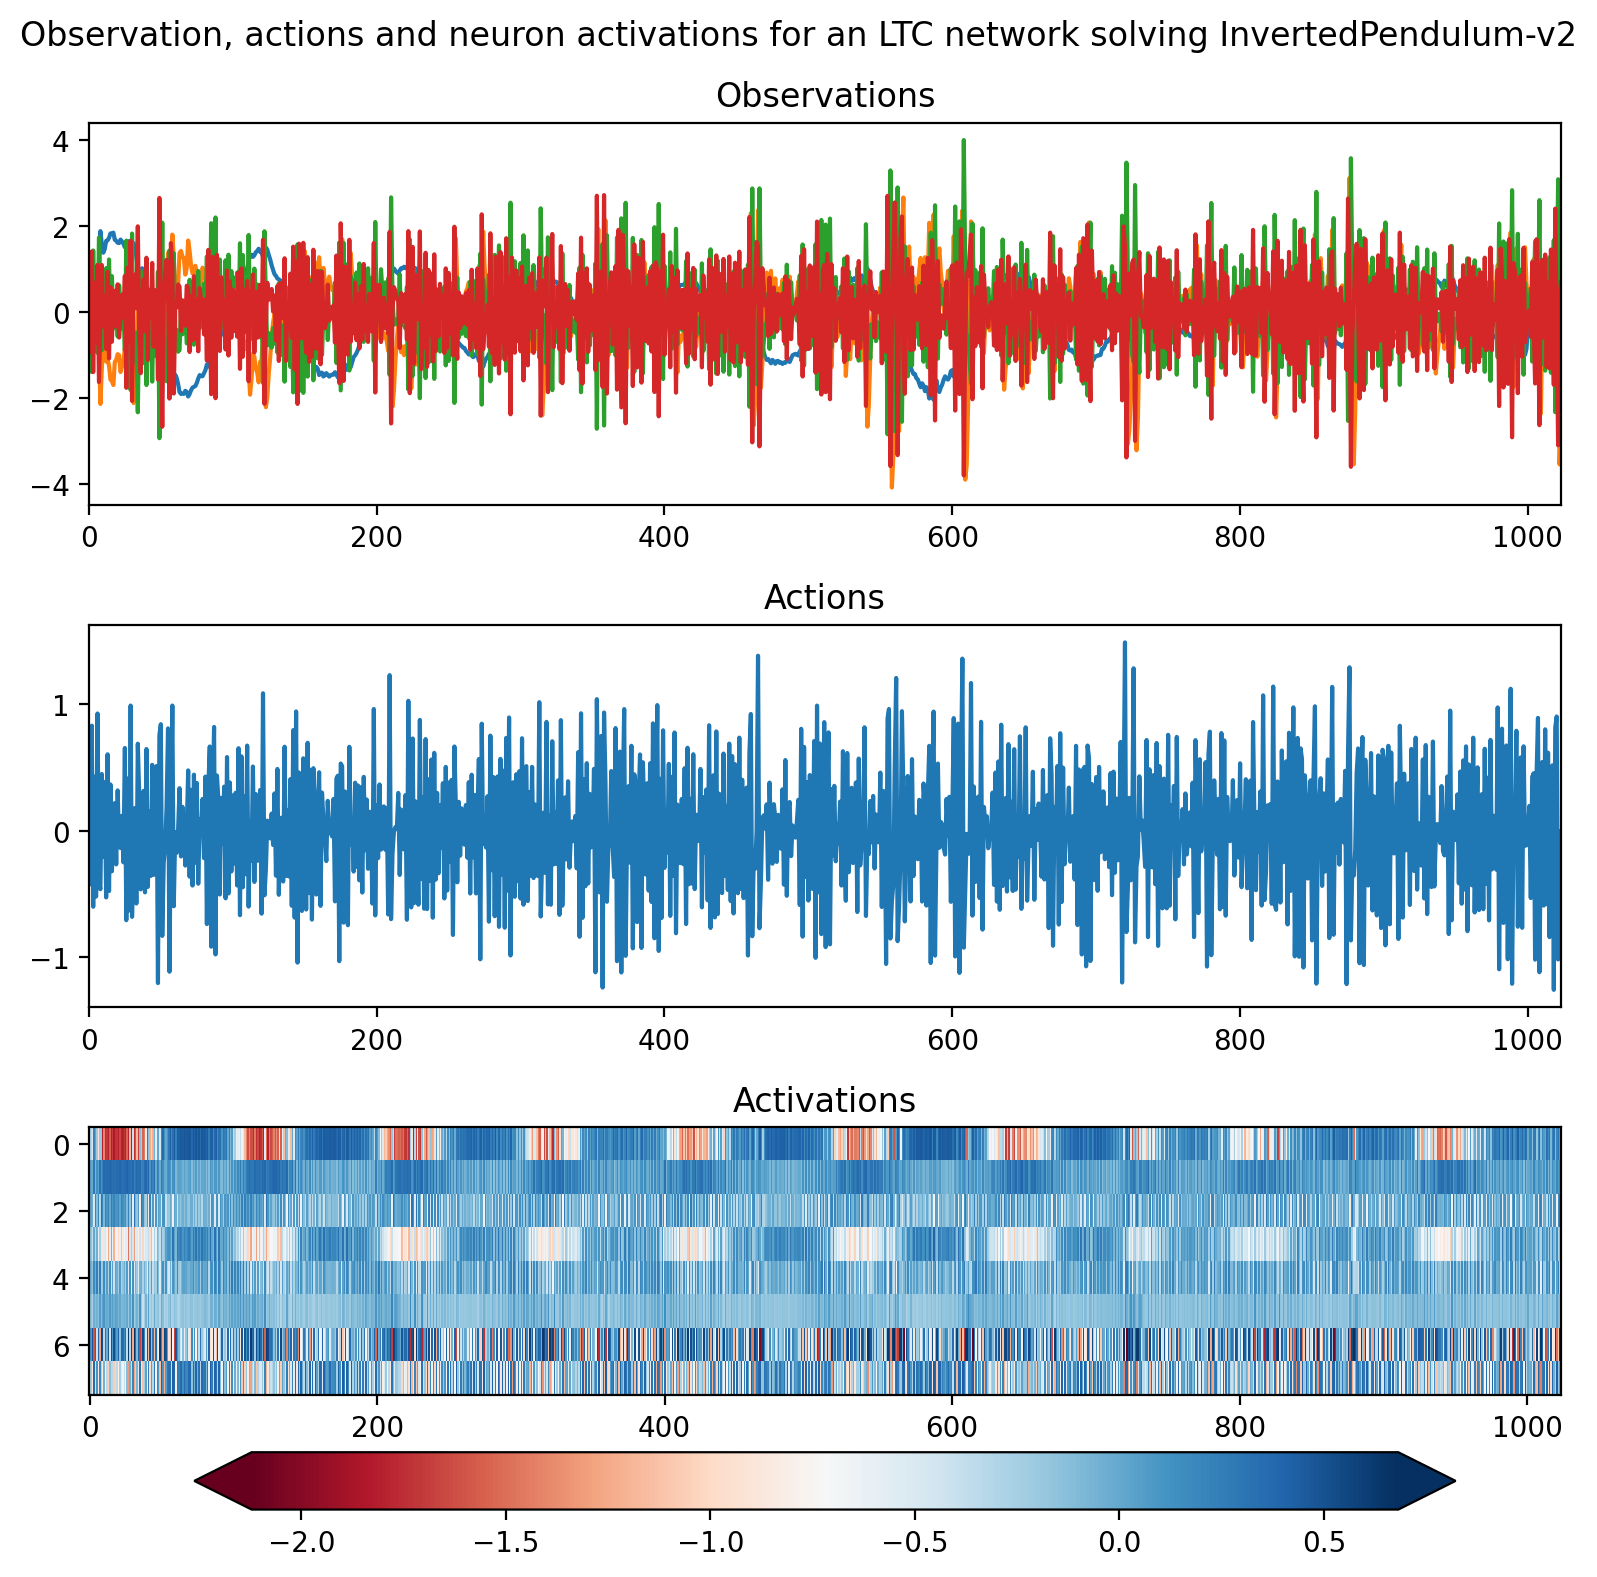

In [57]:
plt.rcParams["figure.figsize"]=8,8
plt.rcParams["figure.dpi"]=200
state_action_obs_plot(trajectory)

## Quiver per state

## Phase action/value plots

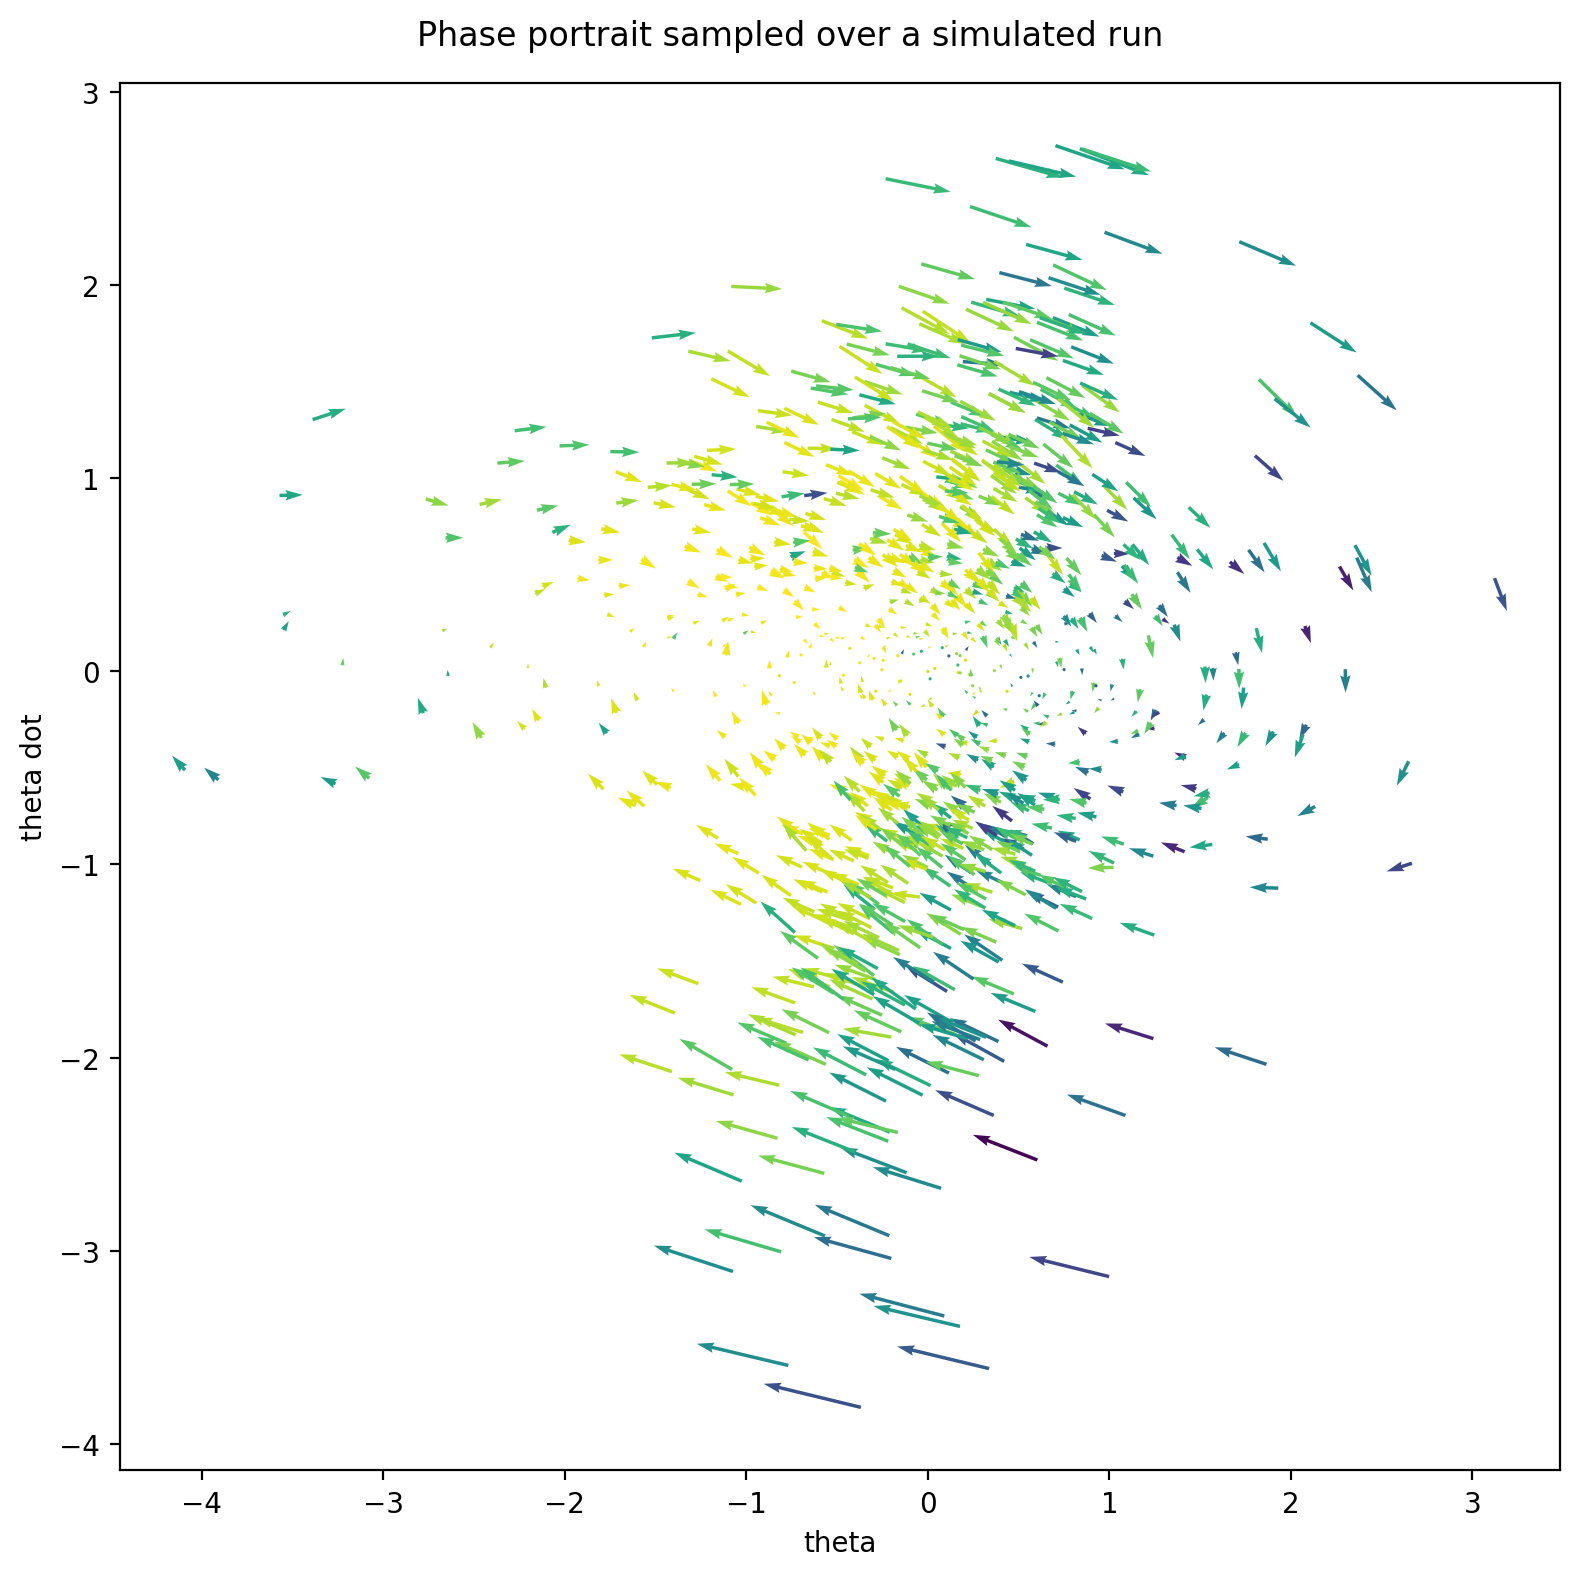

In [54]:
plt.rcParams["figure.figsize"]=8,8
plt.rcParams["figure.dpi"]=200

_theta = trajectory['observations'][:,1]
_theta_dot = trajectory['observations'][:,3]

# making a quiver plot
fig, ax = plt.subplots()
x = _theta
y = _theta_dot
u = _theta_dot
v = -trajectory['actions'][:,0]
c = trajectory['values'][:,0]
q = ax.quiver(x,y,u,v, c)
ax.set(xlabel='theta', ylabel='theta dot')

fig.suptitle('Phase portrait sampled over a simulated run')
fig.tight_layout()

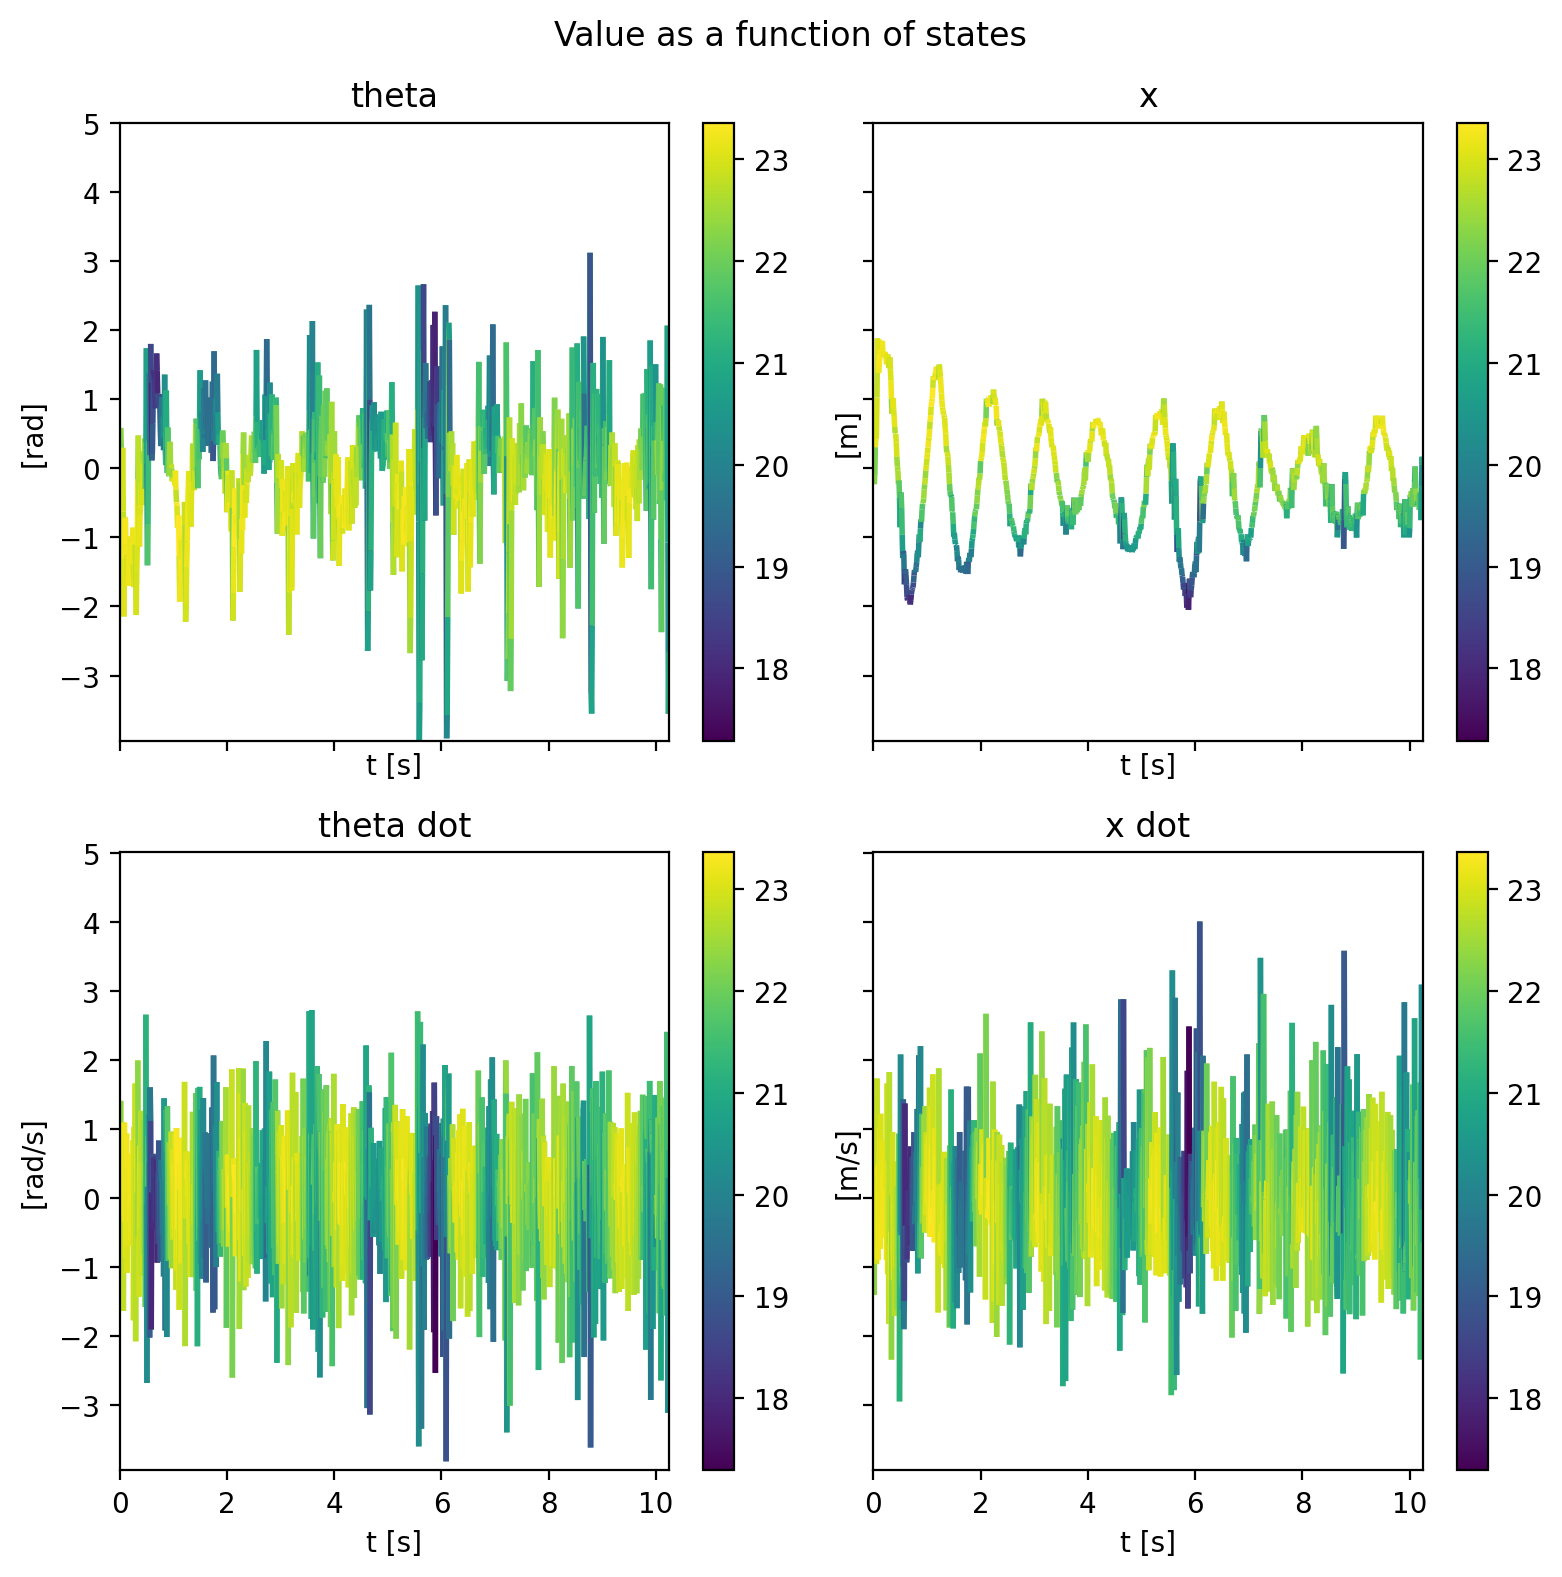

In [66]:
plt.rcParams["figure.figsize"]=8,8
plt.rcParams["figure.dpi"]=200

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm


_x = trajectory['observations'][:,0]
_x_dot = trajectory['observations'][:,2]
_theta = trajectory['observations'][:,1]
_theta_dot = trajectory['observations'][:,3]
_values = trajectory['values'][:,0]
_t = np.linspace(0, 0.01 * _theta.shape[0], _theta.shape[0])

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)


def _plot_colored_lines(x,y,color,ax,title=None,xlabel=None,ylabel=None):
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    norm = plt.Normalize(color.min(), color.max())
    lc = LineCollection(segments, cmap='viridis', norm=norm)
    # Set the values used for colormapping
    lc.set_array(color)
    lc.set_linewidth(2)
    line = ax.add_collection(lc)
    fig.colorbar(line, ax=ax)
    
    if title:
        ax.set_title(title)
    if xlabel:
        ax.set(xlabel=xlabel)
    if ylabel:
        ax.set_title(title)
        ax.set(ylabel=ylabel)
    
    
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(y.min()-1, y.max()+1)

_plot_colored_lines(_t,_theta,_values,axs[0,0],title='theta',xlabel='t [s]',ylabel='[rad]')
_plot_colored_lines(_t,_theta_dot,_values,axs[1,0],title='theta dot',xlabel='t [s]',ylabel='[rad/s]')
_plot_colored_lines(_t,_x,_values,axs[0,1],title='x',xlabel='t [s]',ylabel='[m]')
_plot_colored_lines(_t,_x_dot,_values,axs[1,1],title='x dot',xlabel='t [s]',ylabel='[m/s]')

fig.suptitle('Value as a function of states')
fig.tight_layout()
plt.show()

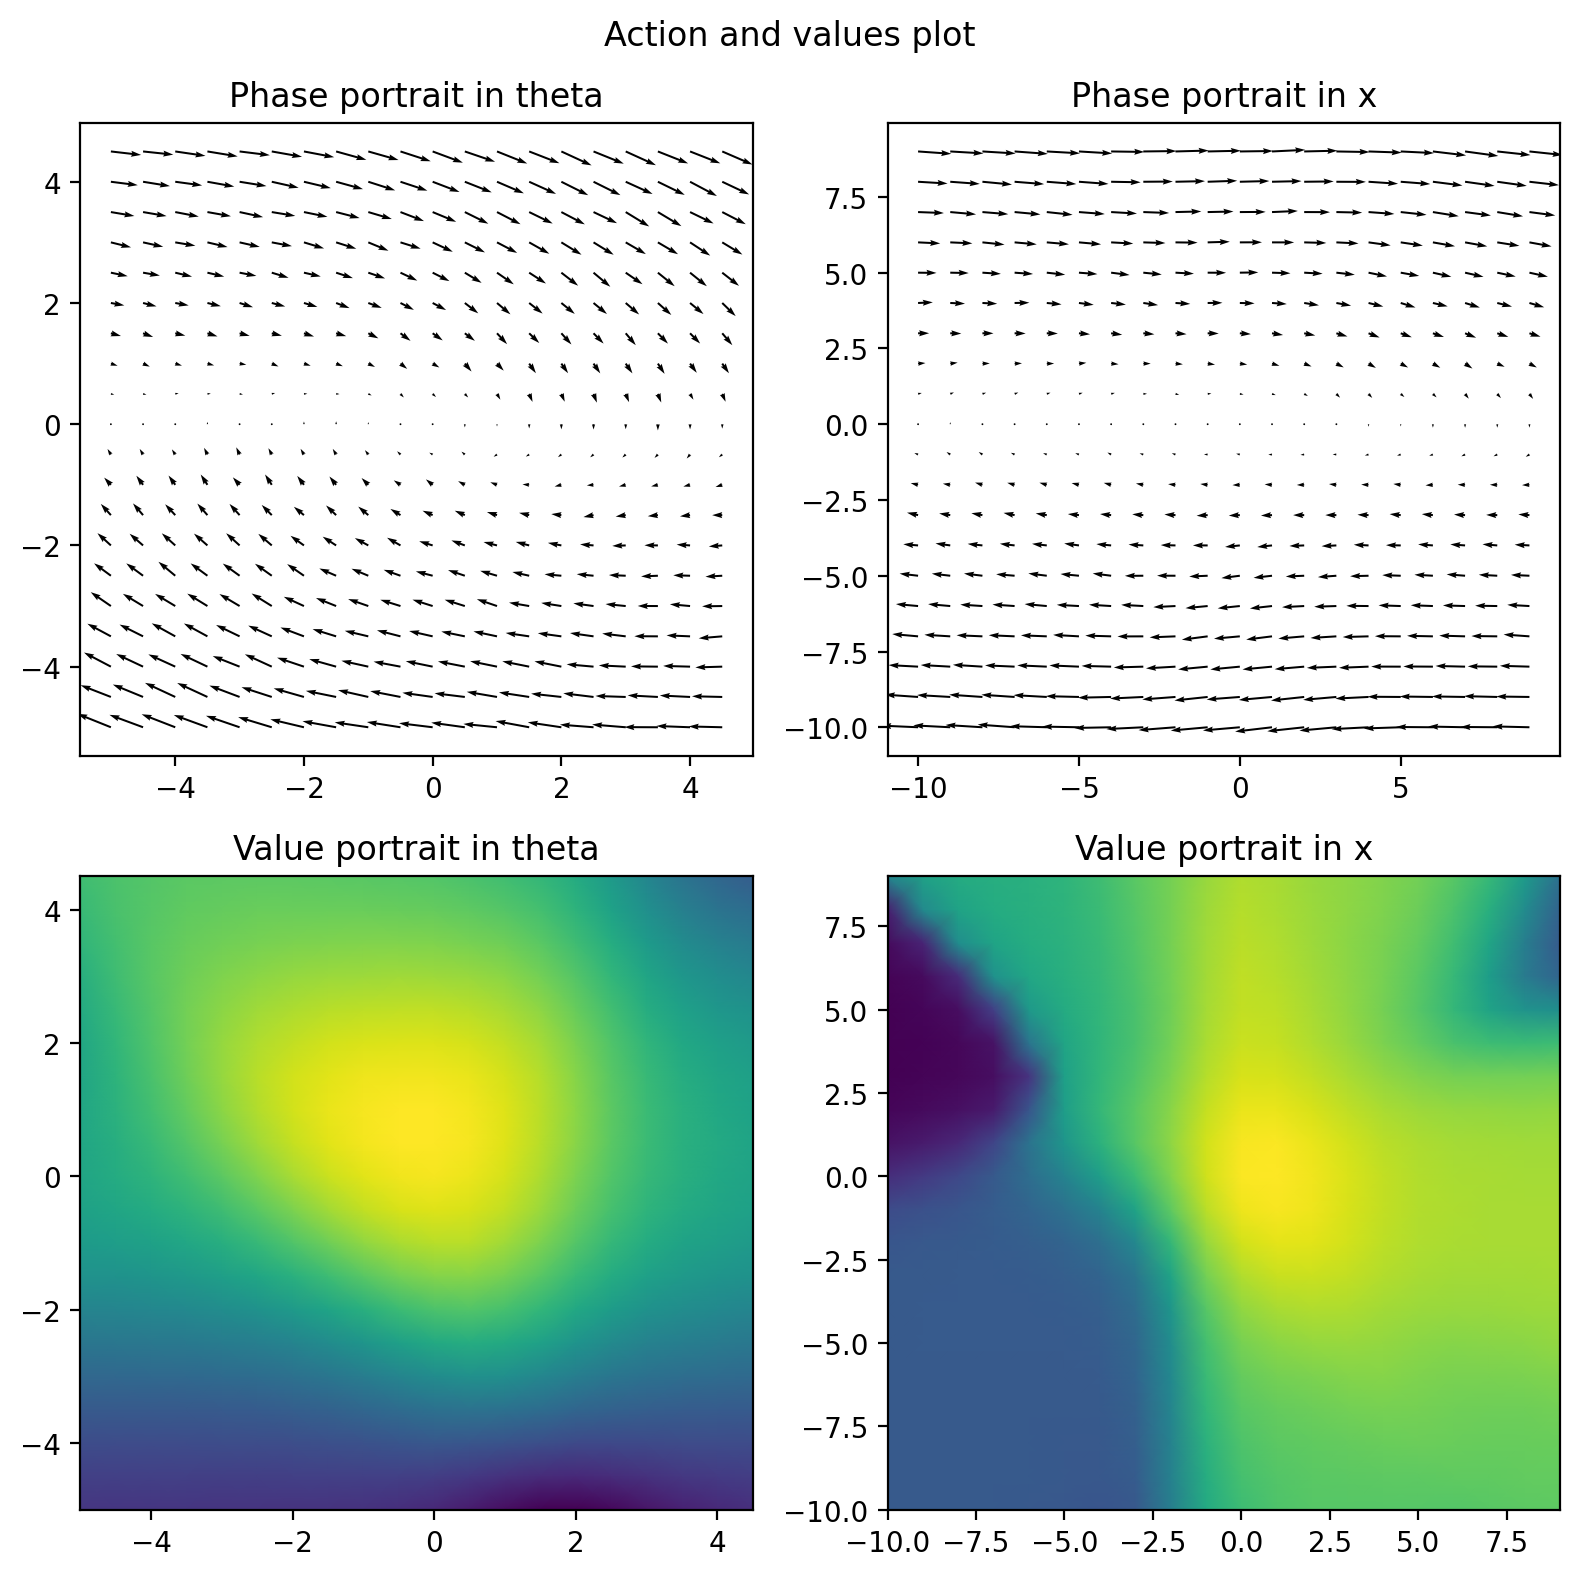

In [175]:
plt.rcParams["figure.figsize"]=8,8
plt.rcParams["figure.dpi"]=200

from collections import namedtuple

_states_action = trajectory['states'][:,0,:,:]
_states_values = trajectory['states'][:,1,:,:]
State = namedtuple("State", "policy value")


t = 2

_s_a_t = _states_action[t,:,:]
_s_v_t = _states_values[t,:,:]
st = State(_states_action[t,:],_states_values[t,:])

def explore_phase(state, bounds = [-4,4,0.1],coord="angle"):
    # obs should be generated by the meshgrid
    # state should be passed should be generated by the meshgrid
    # 4 outputs : x,y,a, u
    def _sample_policy(state,obs):
        _out, _ = runner.policy.act(obs,state=state)
        _act = _out['actions'][0]
        _val = _out['values'][0]
        return _act, _val
    
    # yeah this is an implementation nightmare but my time is worth more than my CPU time
    X = list(np.arange(*bounds))
    Y = list(np.arange(*bounds))
    U = []
    V = []
    x = []
    y = []
    for _x in X:
        _x_col = []
        _y_col = []
        _u_col = []
        _v_col = []
        for _y in Y:
            if coord=="angle":
                _obs = np.array([0,_x,0,_y])
            if coord=="pos":
                _obs = np.array([_x,0,_y,0])
            _act, _val = _sample_policy(st,_obs)
            _x_col.append(_x)
            _y_col.append(_y)
            _u_col.append(_act)
            _v_col.append(_val)
        U.append(_u_col)
        V.append(_v_col)
        x.append(_x_col)
        y.append(_y_col)
    U = np.array(U)
    V = np.array(V)
    X = np.array(x)
    Y = np.array(y)
    return X,Y,U,V


def plot_phase(st, ax, bounds = [-3,3,1]):
    x,y,u,v = explore_phase(st, bounds =bounds)
    q = ax.quiver(x, y, y, -u,v)
def plot_phase_and_val(st, ax1, ax2, bounds = [-3,3,1],coord='angle'):
    x,y,u,v = explore_phase(st, bounds =bounds,coord=coord)
    ax1.quiver(x, y, y, -u)
    ax2.pcolormesh(x,y,v, shading='gouraud')


lims = 10
res = 0.5

fig, axs = plt.subplots(2,2)
plot_phase_and_val(State(_states_action[2,:],_states_values[2,:]), axs[0,0], axs[1,0], bounds = [-lims/2,lims/2,res],coord='angle')
plot_phase_and_val(State(_states_action[2,:],_states_values[2,:]), axs[0,1], axs[1,1], bounds = [-lims,lims,res*2],coord='pos')
fig.suptitle('Action and values plot')
axs[0, 0].set_title('Phase portrait in theta')
axs[1, 0].set_title('Value portrait in theta')
axs[0, 1].set_title('Phase portrait in x')
axs[1, 1].set_title('Value portrait in x')

fig.tight_layout()

## Activation Correlation

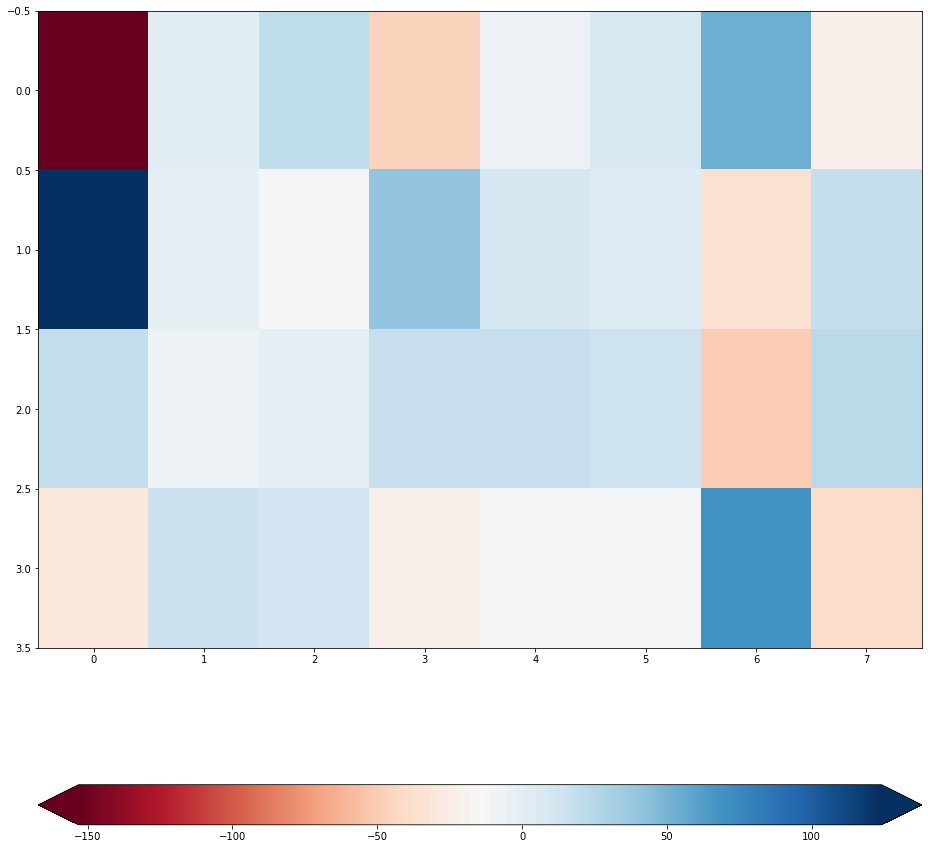

In [ ]:
plt.rcParams["figure.figsize"]=13,13

obs = trajectory['observations']
act = trajectory['actions']
policy_states = trajectory['states'][:,0,0,:]
fig, ax = plt.subplots()

act_neuron = np.transpose(policy_states)

# state_0_corr = act_neuron*obs[:,0]
# state_1_corr = act_neuron*obs[:,1]
# state_2_corr = act_neuron*obs[:,2]
# state_3_corr = act_neuron*obs[:,3]
# act_corr = act_neuron*act[:,0]

out = []
for i in range(act_neuron.shape[0]):
    row = []
    for j in range(4):
        row.append(np.correlate(act_neuron[i,:],obs[:,j]))
    out.append(np.array(row))
out = np.array(out)[:,:,0]

activations = ax.imshow(np.transpose(out),aspect="auto", cmap='RdBu',interpolation = 'nearest')
_ = fig.colorbar(activations, ax=ax,orientation="horizontal", extend='both')

fig.tight_layout()
plt.show()

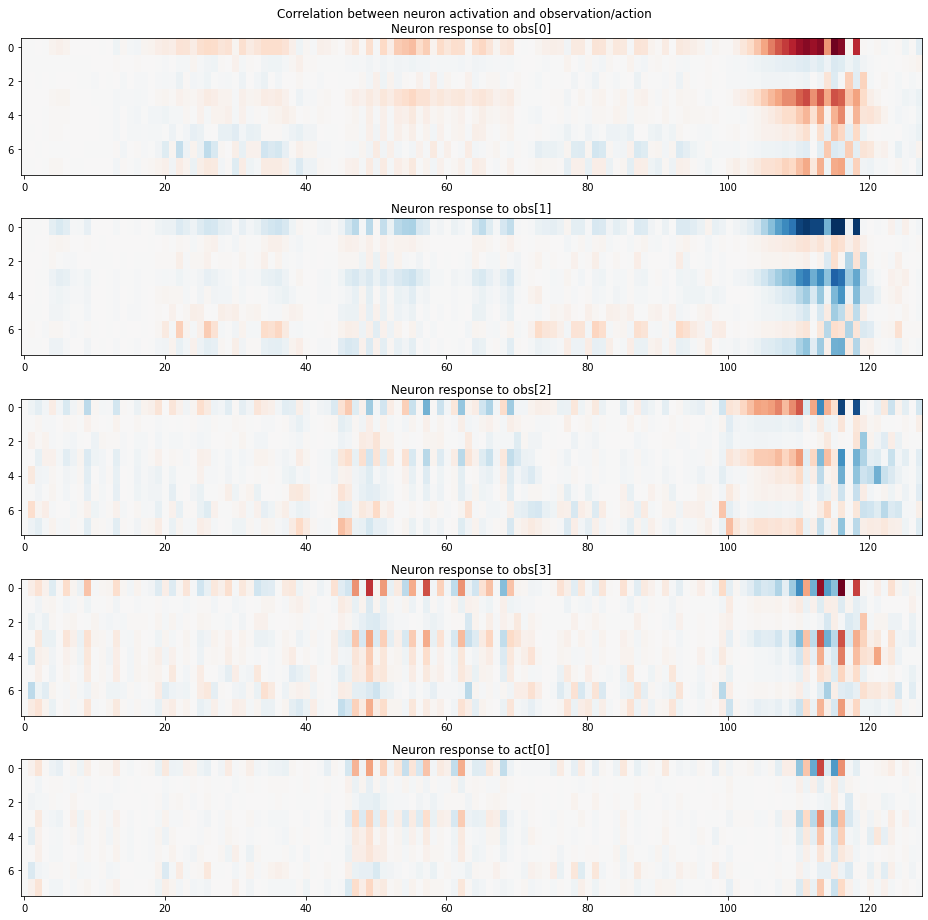

In [ ]:
plt.rcParams["figure.figsize"]=13,13

obs = trajectory['observations']
act = trajectory['actions']
policy_states = trajectory['states'][:,0,0,:]
fig, axs = plt.subplots(5,1)

act_neuron = np.transpose(policy_states)

state_0_corr = act_neuron*obs[:,0]
state_1_corr = act_neuron*obs[:,1]
state_2_corr = act_neuron*obs[:,2]
state_3_corr = act_neuron*obs[:,3]
act_corr = act_neuron*act[:,0]

bounds = 5.

_cmap = 'RdBu'

activations_1 = axs[0].imshow(state_0_corr,aspect="auto", cmap=_cmap,interpolation = 'nearest',vmin=-bounds,vmax=bounds)
axs[0].set_title("Neuron response to obs[0]")
activations_1 = axs[1].imshow(state_1_corr,aspect="auto", cmap=_cmap,interpolation = 'nearest',vmin=-bounds,vmax=bounds)
axs[1].set_title("Neuron response to obs[1]")
activations_1 = axs[2].imshow(state_2_corr,aspect="auto", cmap=_cmap,interpolation = 'nearest',vmin=-bounds,vmax=bounds)
axs[2].set_title("Neuron response to obs[2]")
activations_1 = axs[3].imshow(state_3_corr,aspect="auto", cmap=_cmap,interpolation = 'nearest',vmin=-bounds,vmax=bounds)
axs[3].set_title("Neuron response to obs[3]")
activations_1 = axs[4].imshow(act_corr,aspect="auto", cmap=_cmap,interpolation = 'nearest',vmin=-bounds,vmax=bounds)
axs[4].set_title("Neuron response to act[0]")

fig.suptitle('Correlation between neuron activation and observation/action')

fig.tight_layout()


## LTC Cell vizulization

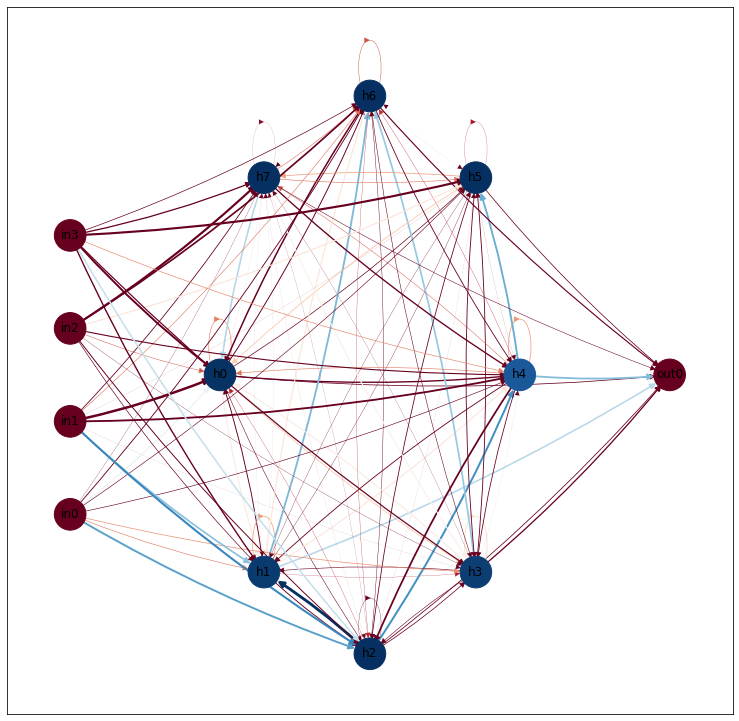

In [ ]:
t = 100

obs = trajectory['observations'][t,:]
act = trajectory['actions'][t,:]
policy_states = trajectory['states'][t,0,0,:]


plot_ltc_cell(obs, act, policy_states, policy_object,node_size=1000)



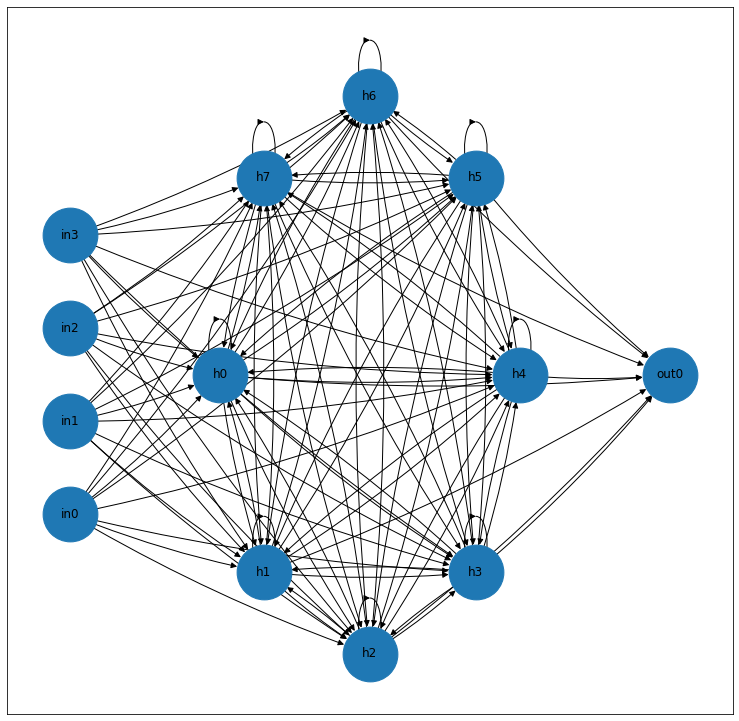

In [ ]:
import networkx as nx
def plot_ltc_structure(inputs,hidden,outputs):
    _ccode = plt.get_cmap(_cmap)

    def network_to_nx(inputs,hidden,outputs):
        G = nx.DiGraph(directed=True)
        time_constant = policy_object.model.policy.weights[6].numpy()[0,:]
        
        for i in range(hidden):
            n = 'h{}'.format(i)
            G.add_node(n)
        for i in range(hidden):
            for j in range(hidden):
                G.add_edge('h{}'.format(i),'h{}'.format(j))  
        
        pos = nx.shell_layout(G)
        
        for i in range(inputs):
            n = 'in{}'.format(i)
            G.add_node(n)
            pos[n] = np.array([-2,  i/((inputs+2)/2) - 0.5 ])
        for i in range(outputs):
            n = 'out{}'.format(i)
            G.add_node(n, weight=1)
            pos[n] = np.array([2,  i/(outputs/2) ])
        
        for i in range(inputs):
            for j in range(hidden):
                G.add_edge('in{}'.format(i),'h{}'.format(j))  
        for i in range(hidden):
            for j in range(outputs):
                G.add_edge('h{}'.format(i),'out{}'.format(j))  
                
        return G, pos

    G, pos = network_to_nx(inputs,hidden,outputs)

        
    options = {
        'node_size': 3000,
        'arrowstyle': '-|>',
        'arrowsize': 12,
    }

    nx.draw_networkx(G,pos, arrows=True, **options,connectionstyle='arc3, rad = 0.05')
    plt.show()
    
plot_ltc_structure(4,8,1)